In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls drive/MyDrive/Research/Spectre/

lightning_logs	    selfiesDecoder.pt		smiles_encoder_decoder.pt  smiles_to_selfies.pt
logs		    smiles_encoder_decoder1.pt	smiles_to_selfies1.pt	   workspace
selfiesDecoder1.pt  smiles_encoder_decoder2.pt	smiles_to_selfies_full.pt


In [ ]:
%cd drive/MyDrive/Research/Spectre/

/content/drive/.shortcut-targets-by-id/1m4PtNtnG5Yi9MGoVlNyrqoI3B-Y6n_GG/Spectre


In [ ]:
!pip install deepchem
!pip install selfies
!pip install rdkit
!pip install pytorch-lightning
!pip install torcheval

In [ ]:
import pytorch_lightning as pl
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
import selfies as sf
from deepchem.feat.smiles_tokenizer import SmilesTokenizer
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torch.optim.lr_scheduler import CosineAnnealingLR
from torcheval.metrics.functional import perplexity
import numpy as np

from rdkit import Chem
from rdkit.Chem import AllChem

from IPython.display import display

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.
Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [ ]:
import pandas as pd

data_path = "workspace/SMILES_dataset/"

smiles_train = pd.read_csv(data_path + "train/SMILES/train.txt", header=None).values.flatten()
smiles_val = pd.read_csv(data_path + "val/SMILES/val.txt", header=None).values.flatten()
smiles_test = pd.read_csv(data_path + "test/SMILES/test.txt", header=None).values.flatten()

smiles = np.concatenate((smiles_train, smiles_val, smiles_test))

In [ ]:
class BaseTokenizer:
    def encoder(self, x:str):
        raise NotImplementedError
    def decoder(self):
        raise NotImplementedError

class SelfiesTokenizer(BaseTokenizer):
    def __init__(self) -> None:
        super().__init__()
    def encoder(self, x):
        return sf.encoder(x)
    def decoder(self, x):
        return sf.decoder(x)

In [ ]:
vocab_path = '/content/drive/MyDrive/Research/Spectre/workspace/vocab.txt'
smiles_tokenizer = SmilesTokenizer(vocab_path)
selfies_tokenizer = SelfiesTokenizer()

# Dataset

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# DEVICE = "cpu"
BATCH_SIZE = 64
PAD_INDEX_SMILES = smiles_tokenizer.pad_token_id
PAD_INDEX_SELFIES = 0
MAX_LEN_SMILES = 463
MAX_LEN_SELFIES = 463 # 457
VOCAB_SIZE = smiles_tokenizer.vocab_size
EMBED_DIM = 64
LATENT_DIM = 1024
NUM_LAYERS = 4
NUM_HEADS = 8
LEARNING_RATE = 1e-3
FEEDFORWARD_DIM = 4*EMBED_DIM
NUM_EPOCHS = 7

In [ ]:
class SmilestoSelfiesDataset(Dataset):
    def __init__(self, smiles, smiles_tokenizer, selfies_tokenizer):
        # Smiles
        self.max_len_smiles = MAX_LEN_SMILES
        self.smiles_encodings = []
        self.PADDING_INDEX_SMILES = PAD_INDEX_SMILES

        # Selfies
        selfies = []
        for x in tqdm(smiles):
            try:
                selfies.append(selfies_tokenizer.encoder(x))
                self.smiles_encodings.append(smiles_tokenizer.add_padding_tokens(smiles_tokenizer.encode(x), length=self.max_len_smiles))
            except:
                continue

        self.alphabet = set()
        for s in selfies:
            self.alphabet.update(sf.split_selfies(s))
        self.alphabet = ['[PAD]','[START]','[END]'] + list(sorted(self.alphabet))
        self.max_len_selfies = MAX_LEN_SELFIES
        self.symbol_to_idx = {s: i for i, s in enumerate(self.alphabet)}
        self.idx_to_symbol = {i: s for i, s in enumerate(self.alphabet)}
        self.selfies_encodings = [[self.symbol_to_idx[symbol] for symbol in sf.split_selfies(s)] for s in selfies]
        self.PADDING_INDEX_SELFIES = self.symbol_to_idx['[PAD]']

    def __len__(self):
        return len(self.smiles_encodings)

    def __getitem__(self, i):
        x = torch.tensor(self.smiles_encodings[i])
        mask = torch.zeros(x.shape, dtype=torch.int32).masked_fill_(x != self.PADDING_INDEX_SMILES, 1)
        mask = mask.type(torch.LongTensor).float()
        y = torch.tensor([self.symbol_to_idx['[START]']]
                          + self.selfies_encodings[i]
                          + [self.symbol_to_idx['[END]']]
                          + [self.symbol_to_idx['[PAD]'] for i in range(self.max_len_selfies - 2 - len(self.selfies_encodings[i]))])
        item = {
            "x": x,
            "y": y,
            "mask": mask
        }
        return item

In [ ]:
dataset = SmilestoSelfiesDataset(smiles, smiles_tokenizer, selfies_tokenizer)

# train_dataset, val_dataset = Subset(dataset, range(len(smiles_train))), Subset(dataset, range(len(smiles_train), len(smiles)))
train_dataset, val_dataset = random_split(dataset, [int(round(len(dataset) * 0.8)), int(round(len(dataset) * 0.2))])

100%|██████████| 137267/137267 [02:18<00:00, 990.59it/s]


In [ ]:
# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, drop_last=True, pin_memory=True)

# Models

In [ ]:
import functools
import math

def _cosine_decay_warmup(iteration, warmup_iterations, total_iterations, min_mult):
    """
    Linear warmup from 0 --> 1.0, then decay using cosine decay to 0.1
    """
    if iteration <= warmup_iterations:
        multiplier = iteration / warmup_iterations
    else:
        if iteration >= total_iterations:
            multiplier = min_mult
        else:
            multiplier = (iteration - warmup_iterations) / (total_iterations - warmup_iterations)
            multiplier = max(min_mult, 0.5 * (1 + math.cos(math.pi * multiplier)))
    return multiplier

def CosineAnnealingLRWarmup(optimizer, T_max, T_warmup, min_mult=0.01):
    _decay_func = functools.partial(
        _cosine_decay_warmup,
        warmup_iterations=T_warmup, total_iterations=T_max, min_mult=min_mult
    )
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, _decay_func)
    return scheduler

def DummyLRWarmup(optimizer, T_max, T_warmup, min_mult=0.01):
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda x: 1)
    return scheduler

class VAE(pl.LightningModule):
    def __init__(
            self,
            max_len,
            vocab_len,
            latent_dim,
            embedding_dim,
            autoreg=False,
            use_z_surrogate=False):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.max_len = max_len
        self.vocab_len = vocab_len
        self.embedding_dim = embedding_dim
        self.autoreg = autoreg
        self.use_z_surrogate = use_z_surrogate
        self.independent_surrogate = False
        self.init_modules()

        self.surr_properties = ["sa", "qed", "ba"]
        if self.use_z_surrogate:
            self.z_surrogates = nn.ModuleDict(
                dict(
                    (s, nn.Sequential(
                                    nn.Linear(self.latent_dim, 1024),
                                    nn.BatchNorm1d(1024),
                                    nn.ReLU(),
                                    nn.Linear(1024, 128),
                                    nn.BatchNorm1d(128),
                                    nn.ReLU(),
                                    nn.Linear(128, 1)))
                    for s in self.surr_properties
                )
            )

    def init_modules(self):
        self.embedding = nn.Embedding(self.vocab_len, self.embedding_dim, padding_idx=0)
        self.encoder = nn.Sequential(nn.Linear(self.max_len * self.embedding_dim, 2000),
                                     nn.ReLU(),
                                     nn.Linear(2000, 1000),
                                     nn.BatchNorm1d(1000),
                                     nn.ReLU(),
                                     nn.Linear(1000, 1000),
                                     nn.BatchNorm1d(1000),
                                     nn.ReLU(),
                                     nn.Linear(1000, self.latent_dim * 2))
        self.decoder = nn.Sequential(nn.Linear(self.latent_dim, 1000),
                                     nn.BatchNorm1d(1000),
                                     nn.ReLU(),
                                     nn.Linear(1000, 1000),
                                     nn.BatchNorm1d(1000),
                                     nn.ReLU(),
                                     nn.Linear(1000, 2000),
                                     nn.ReLU(),
                                     nn.Linear(2000,self. max_len * self.vocab_len))


    def encode(self, x):
        x = self.encoder(self.embedding(x).view((len(x), -1))).view((-1, 2, self.latent_dim))
        mu, log_var = x[:, 0, :], x[:, 1, :]
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std, mu, log_var

    def decode(self, z):
        return F.log_softmax(self.decoder(z).view((-1, self.max_len, self.vocab_len)), dim=2).view((-1, self.max_len * self.vocab_len))

    def forward(self, **input):
        x = input['x']
        z, mu, log_var = self.encode(x)
        return self.decode(z), z, mu, log_var

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.0001)
        scheduler = CosineAnnealingLRWarmup(
            optimizer, T_max=50000, T_warmup=100, min_mult=0.01)
        # scheduler = DummyLRWarmup(
        #     optimizer, T_max=50000, T_warmup=100, min_mult=0.01)
        return [optimizer], [{"scheduler": scheduler, "interval": "step"}]


    def loss_function(self, pred, target, mu, log_var, batch_size, p):
        if self.autoreg:
            nll = F.nll_loss(pred, target, ignore_index=PAD_INDEX_SMILES)
        else:
            nll = F.nll_loss(pred, target)
        kld = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) / (batch_size * pred.shape[1])
        return nll + p * kld, nll, kld

    def training_step(self, train_batch, batch_idx):
        out, z, mu, log_var = self(**train_batch)
        p = 0.1 * (min((self.global_step % 1000) / 1000, 0.5)*2) # 0.01 #min(self.current_epoch/10, 0.1)  #0.1
        loss, nll, kld = self.loss_function(out.reshape((-1, self.vocab_len)), train_batch["x"].flatten(), mu, log_var, len(train_batch["x"]), p)

        self.log('train_loss', loss)
        self.log('train_nll', nll)
        self.log('train_kld', kld)
        return loss

    def validation_step(self, val_batch, batch_idx):
        out, z, mu, log_var = self(**val_batch)
        p = 0.1 * (min((self.global_step % 1000) / 1000, 0.5)*2) # 0.01 #min(self.current_epoch/10, 0.1)  #0.1
        loss, nll, kld = self.loss_function(out.reshape((-1, self.vocab_len)), val_batch["x"].flatten(), mu, log_var, len(val_batch["x"]), p)

        self.log('val_loss', loss)
        self.log('val_nll', nll)
        self.log('val_kld', kld)
        self.log('val_mu', torch.mean(mu))
        self.log('val_logvar', torch.mean(log_var))
        return loss

class VAEFormer(VAE):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def init_modules(self):
        self.inp_emb = nn.Embedding(self.vocab_len, self.embedding_dim)
        self.lm_head = nn.Linear(self.embedding_dim, self.vocab_len, bias=False)
        self.inp_emb.weight = self.lm_head.weight # weight tying
        self.time_emb = nn.Parameter(0.02*torch.randn(1, self.max_len, self.embedding_dim))

        self.z_emb = nn.Parameter(0.02*torch.randn(1, self.embedding_dim))
        self.reparametrize = nn.Linear(self.embedding_dim, self.embedding_dim*2)


        self.encoder = nn.TransformerEncoder(
            encoder_layer=nn.TransformerEncoderLayer(
                d_model=self.embedding_dim,
                nhead=8,
                dim_feedforward=self.embedding_dim*4,
                activation="gelu",
                batch_first=True,
                norm_first=True),
            num_layers=4
        )

        enc_prefix = torch.zeros(1, 3, dtype=bool)
        self.register_buffer("enc_prefix", enc_prefix)
        self.decoder = nn.TransformerDecoder(
            decoder_layer=nn.TransformerDecoderLayer(
                d_model=self.embedding_dim,
                nhead=8,
                dim_feedforward=self.embedding_dim*4,
                activation='gelu',
                batch_first=True,
                norm_first=True),# important for stability
            num_layers=4
        )

        sz = self.max_len + 1 # start token
        self.dec_start_token = nn.Parameter(0.02*torch.randn(1, self.embedding_dim))
        # self.tgt_time_emb = nn.Parameter(0.02*torch.randn(1, self.max_len, self.embedding_dim))
        decoder_mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        decoder_mask = ~decoder_mask.bool() #decoder_mask.float().masked_fill(decoder_mask == 0, float('-inf')).masked_fill(decoder_mask == 1, float(0.0))
        self.register_buffer("decoder_mask", decoder_mask)
        self.dec_emb = nn.Parameter(0.02*torch.randn(1, self.max_len, self.embedding_dim))

    def encode(self, x):
        # src_key_mask = torch.stack([row != 0 for row in x], dim=0).bool()
        src_key_mask = x==PAD_INDEX_SMILES
        x = self.inp_emb(x) + self.time_emb
        inp_emb_list = []
        enc_inp_emb = torch.cat(
            [self.z_emb.unsqueeze(0).expand(x.size(0),-1,-1)] +
             inp_emb_list + [x],
            dim=1
        )

        src_key_mask = torch.cat([self.enc_prefix[:, :1+len(inp_emb_list)].expand(x.size(0), -1), src_key_mask],dim=1)
        x = self.encoder(enc_inp_emb, src_key_padding_mask=src_key_mask)
        x = self.reparametrize(x[:, 0])
        mu, log_var = x[:, :self.embedding_dim], x[:, self.embedding_dim:]
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std, mu, log_var

    def decode(self, z, true_targets=None):
        dec_emb_list = []
        dec_inp_emb = torch.cat(
                    [z.unsqueeze(1)] + dec_emb_list +
                    [self.dec_emb.expand(z.size(0), -1, -1)],
                dim=1
            )
        if true_targets is not None:
            # teacher forcing
            tgt = self.inp_emb(true_targets[:, :-1]) + self.time_emb[:, :-1]
            tgt = torch.cat([self.dec_start_token.expand(z.size(0), -1,-1), tgt], dim=1)
            x = self.decoder(
                tgt=tgt,
                memory=dec_inp_emb,
                tgt_mask=self.decoder_mask[:-1,:-1])
            x = self.lm_head(x)
            x[:,:,0] = float('-inf')
        else:
            dec_tokens = [self.dec_start_token.expand(z.size(0), -1).unsqueeze(1)]
            dec_outputs = []
            assert len(self.decoder_mask.shape) == 2
            for i in range(self.max_len):
                x = self.decoder(
                    tgt=torch.cat(dec_tokens, dim=1),
                    memory=dec_inp_emb,
                    tgt_mask=self.decoder_mask[:i+1, :i+1])
                dec_logits = self.lm_head(x[:,-1,:])
                dec_logits[:,0] = float('-inf')
                dec_outputs.append(dec_logits)
                next_token = self.inp_emb(torch.argmax(dec_logits, dim=1)).unsqueeze(1) + self.time_emb[:, i, :]
                dec_tokens.append(next_token)
            x = torch.stack(dec_outputs, dim=1)
        return F.log_softmax(x, dim=-1).view((-1, self.max_len * self.vocab_len))

    def forward(self, **input):
        x = input['x']
        z, mu, log_var = self.encode(x)
        return self.decode(z, x), z, mu, log_var

In [ ]:
class SelfieDecoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_layers, num_heads, feedforward_dim, max_seq_len):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.feedforward_dim = feedforward_dim
        self.max_seq_len = max_seq_len

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        # Positional encoding layer
        self.positional_encoding = nn.Embedding(max_seq_len, embedding_dim)

        # Transformer decoder
        self.decoder = nn.TransformerDecoder(
            decoder_layer=nn.TransformerDecoderLayer(
                d_model=embedding_dim,
                nhead=num_heads,
                dim_feedforward=feedforward_dim,
                activation='gelu',
                batch_first=True,
                norm_first=True
            ),
            num_layers=num_layers
        )

        # Output layer
        self.output_layer = nn.Linear(embedding_dim, vocab_size)

    def forward(self, x, mask):
        # Embed input sequence
        x = self.embedding(x)

        # # Add positional encoding
        positions = torch.arange(x.shape[1], device=x.device)
        pos_emb = self.positional_encoding(positions)
        x = x + pos_emb

        # Decode
        x = self.decoder(x, x, tgt_key_padding_mask=mask)

        # Output layer
        x = self.output_layer(x)

        return x

    def generate(self, context, max_new_tokens=400):
        # idx is (B,T) array of indices in the current context
        for _ in range(max_new_tokens):
            #crop context to the last block_size tokens
            context_truncated = context[:, -self.max_seq_len:]
            mask = torch.ones(context_truncated.shape, device=DEVICE)
            mask = mask.masked_fill_(context_truncated != 0, 1.0)
            mask = mask.type(torch.LongTensor).float()
            # get the predictions
            context_truncated = context_truncated.to(DEVICE)
            mask = mask.to(DEVICE)
            logits = self(context_truncated, mask)
            # focus only on the last time step
            logits = logits[:,-1,:] # becomes (B,C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B,C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B,1)
            # append sampled index to the running sequence
            context = torch.cat((context, idx_next), dim = 1)

            if idx_next[0].item() in {dataset.symbol_to_idx['[START]'], dataset.symbol_to_idx['[END]'], dataset.symbol_to_idx['[PAD]']}:
                break

        return context

def run(model, train_dataloader, val_dataloader):
    model.to(DEVICE)
    PADDING_INDEX = dataset.PADDING_INDEX
    criterion = nn.CrossEntropyLoss(ignore_index=PADDING_INDEX)
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
    scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

    train_losses, val_losses, pers = [], [], []
    for iter in range(NUM_EPOCHS):
        print(f"Epoch {iter}")
        model.train()

        train_loss = []
        for idx, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
            xb, yb, maskb = batch
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            maskb = maskb.to(DEVICE)

            optimizer.zero_grad()
            logits = model(xb, maskb)
            loss = criterion(logits.view(-1, VOCAB_SIZE), yb.view(-1))
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        scheduler.step()
        train_losses.append(np.mean(train_loss))
        print(f"Train loss: {np.mean(train_loss)}")

        model.eval()
        val_loss = []
        per = []
        for idx, batch in tqdm(enumerate(val_dataloader), total=len(val_dataloader)):
            xb, yb, maskb = batch
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            maskb = maskb.to(DEVICE)

            logits = model(xb, maskb)
            loss = criterion(logits.view(-1, VOCAB_SIZE), yb.view(-1))
            val_loss.append(loss.item())

        val_losses.append(np.mean(val_loss))
        pers.append(np.exp(np.mean(val_loss)))
        print(f"Val loss: {np.mean(val_loss)}")
        print(f"Perplexity: {pers[-1]}")

    return model, train_losses, val_losses

In [ ]:
smiles_encoder_decoder = torch.load("smiles_encoder_decoder2.pt")
selfies_decoder = torch.load("selfiesDecoder1.pt")

In [ ]:
class SmilestoSelfies(VAE):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def init_modules(self):
        self.inp_emb = smiles_encoder_decoder.inp_emb
        self.lm_head = smiles_encoder_decoder.lm_head
        # self.inp_emb.weight = self.lm_head.weight # weight tying
        self.time_emb = smiles_encoder_decoder.time_emb

        self.z_emb = smiles_encoder_decoder.z_emb
        self.reparametrize = smiles_encoder_decoder.reparametrize

        self.encoder = smiles_encoder_decoder.encoder

        enc_prefix = torch.zeros(1, 3, dtype=bool)
        self.register_buffer("enc_prefix", enc_prefix)
        self.decoder = selfies_decoder.decoder

        sz = self.max_len + 1 # start token
        self.dec_start_token = nn.Parameter(0.02*torch.randn(1, self.embedding_dim))
        # self.tgt_time_emb = nn.Parameter(0.02*torch.randn(1, self.max_len, self.embedding_dim))
        decoder_mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        decoder_mask = ~decoder_mask.bool() #decoder_mask.float().masked_fill(decoder_mask == 0, float('-inf')).masked_fill(decoder_mask == 1, float(0.0))
        self.register_buffer("decoder_mask", decoder_mask)
        self.dec_emb = nn.Parameter(0.02*torch.randn(1, self.max_len, self.embedding_dim))

    def encode(self, x):
        # src_key_mask = torch.stack([row != 0 for row in x], dim=0).bool()
        src_key_mask = x==PAD_INDEX_SMILES
        x = self.inp_emb(x) + self.time_emb
        inp_emb_list = []
        enc_inp_emb = torch.cat(
            [self.z_emb.unsqueeze(0).expand(x.size(0),-1,-1)] +
             inp_emb_list + [x],
            dim=1
        )

        src_key_mask = torch.cat([self.enc_prefix[:, :1+len(inp_emb_list)].expand(x.size(0), -1), src_key_mask],dim=1)
        x = self.encoder(enc_inp_emb, src_key_padding_mask=src_key_mask)
        x = self.reparametrize(x[:, 0])
        mu, log_var = x[:, :self.embedding_dim], x[:, self.embedding_dim:]
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std, mu, log_var

    def decode(self, z, true_targets=None):
        dec_emb_list = []
        dec_inp_emb = torch.cat(
                    [z.unsqueeze(1)] + dec_emb_list +
                    [self.dec_emb.expand(z.size(0), -1, -1)],
                dim=1
            )
        if true_targets is not None:
            # teacher forcing
            tgt = self.inp_emb(true_targets[:, :-1]) + self.time_emb[:, :-1]
            tgt = torch.cat([self.dec_start_token.expand(z.size(0), -1,-1), tgt], dim=1)
            x = self.decoder(
                tgt=tgt,
                memory=dec_inp_emb,
                tgt_mask=self.decoder_mask[:-1,:-1])
            x = self.lm_head(x)
            x[:,:,0] = float('-inf')
        else:
            dec_tokens = [self.dec_start_token.expand(z.size(0), -1).unsqueeze(1)]
            dec_outputs = []
            assert len(self.decoder_mask.shape) == 2
            for i in range(self.max_len):
                x = self.decoder(
                    tgt=torch.cat(dec_tokens, dim=1),
                    memory=dec_inp_emb,
                    tgt_mask=self.decoder_mask[:i+1, :i+1])
                dec_logits = self.lm_head(x[:,-1,:])
                dec_logits[:,0] = float('-inf')
                dec_outputs.append(dec_logits)
                next_token = self.inp_emb(torch.argmax(dec_logits, dim=1)).unsqueeze(1) + self.time_emb[:, i, :]
                dec_tokens.append(next_token)
            x = torch.stack(dec_outputs, dim=1)
        return F.log_softmax(x, dim=-1).view((-1, self.max_len * self.vocab_len))

    def forward(self, **input):
        x = input['x']
        y = input['y']
        z, mu, log_var = self.encode(x)
        return self.decode(z, y), z, mu, log_var

    def training_step(self, train_batch, batch_idx):
        # print("New Trainer")
        out, z, mu, log_var = self(**train_batch)
        p = 0.1 * (min((self.global_step % 1000) / 1000, 0.5)*2) # 0.01 #min(self.current_epoch/10, 0.1)  #0.1
        loss, nll, kld = self.loss_function(out.reshape((-1, self.vocab_len)), train_batch["y"].flatten(), mu, log_var, len(train_batch["x"]), p)

        self.log('train_loss', loss)
        self.log('train_nll', nll)
        self.log('train_kld', kld)
        return loss

    def validation_step(self, val_batch, batch_idx):
        # print("New Validator")
        out, z, mu, log_var = self(**val_batch)
        p = 0.1 * (min((self.global_step % 1000) / 1000, 0.5)*2) # 0.01 #min(self.current_epoch/10, 0.1)  #0.1
        loss, nll, kld = self.loss_function(out.reshape((-1, self.vocab_len)), val_batch["y"].flatten(), mu, log_var, len(val_batch["x"]), p)

        self.log('val_loss', loss)
        self.log('val_nll', nll)
        self.log('val_kld', kld)
        self.log('val_mu', torch.mean(mu))
        self.log('val_logvar', torch.mean(log_var))
        return loss

<ipython-input-17-fa223fd9afb9>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  smiles_encoder_decoder = torch.load("smiles_encoder_decoder2.pt")
<ipython-input-17-fa223fd9

In [ ]:
model = SmilestoSelfies(max_len=MAX_LEN_SMILES, vocab_len=VOCAB_SIZE,
            latent_dim=LATENT_DIM, embedding_dim=EMBED_DIM, autoreg=True, use_z_surrogate=False)
# model = torch.load("smiles_to_selfies1.pt").to(DEVICE)

In [ ]:
model

SmilestoSelfies(
  (inp_emb): Embedding(591, 64)
  (lm_head): Linear(in_features=64, out_features=591, bias=False)
  (reparametrize): Linear(in_features=64, out_features=128, bias=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerDecoderLayer(
        (self_

In [ ]:
trainer = pl.Trainer(
            accelerator="gpu",
            num_nodes=1,
            max_epochs=7,
            #max_steps=100000,
            enable_checkpointing=False,
            logger=pl.loggers.CSVLogger(f'logs/stos/'),
            callbacks=[
                pl.callbacks.TQDMProgressBar(refresh_rate=1)
            ])

print('Training..')
trainer.fit(model, train_dataloader, val_dataloader)

if trainer.state.status == "finished":
    print('Saving..')
    torch.save(model, "smiles_to_selfies_full.pt")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Training..


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type               | Params | Mode 
-------------------------------------------------------------
0 | inp_emb       | Embedding          | 37.8 K | train
1 | lm_head       | Linear             | 37.8 K | train
2 | reparametrize | Linear             | 8.3 K  | train
3 | encoder       | TransformerEncoder | 199 K  | train
4 | decoder       | TransformerDecoder | 267 K  | eval 
  | other params  | n/a                | 21.6 K | n/a  
-------------------------------------------------------------
572 K     Trainable params
0         Non-trainable params
572 K     Total params
2.290     Total estimated model params size (MB)
45        Modules in train mode
58        Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=7` reached.


Saving..


In [ ]:
smiles_encoder_decoder.inp_emb[:, :-1].shape

TypeError: 'Embedding' object is not subscriptable

In [ ]:
selfies_decoder.positional_encoding

# Inference

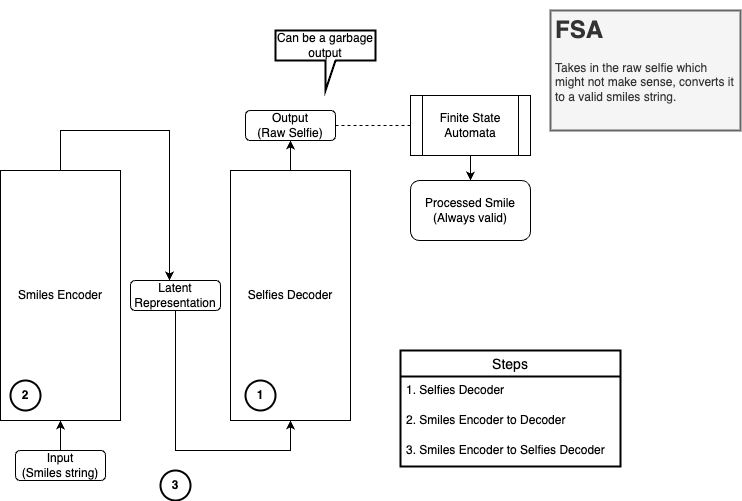

In [ ]:
def get_selfies(seq):
    selfie = ''
    for x in seq:
        x = x.item()
        if x == 1:
            continue
        if x == 2:
            break
        selfie += dataset.idx_to_symbol[x]

    return selfie

def get_smiles(seq):
    smile = ''
    for x in seq:
        x = x.item()
        if x == 12:
            continue
        if x == 13:
            break
        smile += smiles_tokenizer.decode(x)

    return smile

In [ ]:
model.to(DEVICE)

SmilestoSelfies(
  (inp_emb): Embedding(591, 64)
  (lm_head): Linear(in_features=64, out_features=591, bias=False)
  (reparametrize): Linear(in_features=64, out_features=128, bias=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerDecoderLayer(
        (self_

In [ ]:
i = 0
x = val_dataset[i]['x'].unsqueeze(0).to(DEVICE)
y = val_dataset[i]['y'].unsqueeze(0).to(DEVICE)

print("Input Smiles:", get_smiles(x.flatten()))
print("Target Selfies:", get_selfies(y.flatten()))

Input Smiles: C=C1CC(=CC)C(=O)OC2CCN3CC=C(COC(=O)C1(C)O)C23
Target Selfies: [C][=C][C][C][=Branch1][Ring1][=C][C][C][=Branch1][C][=O][O][C][C][C][N][C][C][=C][Branch1][#C][C][O][C][=Branch1][C][=O][C][Ring2][Ring1][Ring2][Branch1][C][C][O][C][Ring1][#C][Ring1][N]


In [ ]:
z, _, _ = model.encode(x)
out = model.decode(z)
out = torch.argmax(out.reshape((-1, model.vocab_len)), dim=1)

In [ ]:
pred = get_selfies(out)
target = get_selfies(y.flatten())

print("Selfies")
print("Target:", target)
print("Pred:", pred)

Selfies
Target: [C][=C][C][C][=Branch1][Ring1][=C][C][C][=Branch1][C][=O][O][C][C][C][N][C][C][=C][Branch1][#C][C][O][C][=Branch1][C][=O][C][Ring2][Ring1][Ring2][Branch1][C][C][O][C][Ring1][#C][Ring1][N]
Pred: [C][=C][C][=C][C][Branch1][C][O][C][Branch1][C][C][C][C][C][C][=Branch1][C][=O][C][C][Ring1][#Branch1][C][Ring1][N][C][=Branch1][C][=O][O][C][Ring1][N][C][Ring2][Ring1][Ring1][Ring2][Ring1]


In [ ]:
#Finite State Automata
smile_pred = selfies_tokenizer.decoder(pred)
smile_tgt = selfies_tokenizer.decoder(target)

print("Smiles")
print("Target:", smile_tgt)
print("Pred:", smile_pred)

Smiles
Target: C=C1CC(=CC)C(=O)OC2CCN3CC=C(COC(=O)C1(C)O)C23
Pred: C=CC1=C2C3(O)C(C)C45CCC(=O)CC4C3C(=O)OC5C12


Target


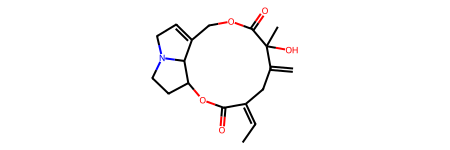

In [ ]:
print("Target")
m = Chem.MolFromSmiles(smile_tgt)
display(m)

Pred


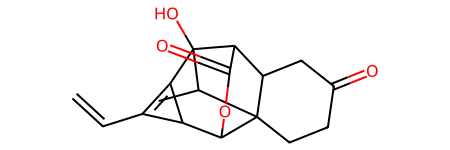

In [ ]:
print("Pred")
m = Chem.MolFromSmiles(smile_pred)
display(m)

# Metrics

In [ ]:
from torch.profiler import profile, record_function, ProfilerActivity

with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        for i, batch in enumerate(tqdm(val_dataloader)):
            x = batch['x'].to(DEVICE)
            y = batch['y'].to(DEVICE)

            z, _, _ = model.encode(x)
            out = model.decode(z)
            out = torch.argmax(out.reshape((-1, model.vocab_len)), dim=1)
            print(out.shape)
            break


  0%|          | 0/428 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 5.06 MiB is free. Process 129523 has 14.74 GiB memory in use. Of the allocated memory 14.41 GiB is allocated by PyTorch, and 195.53 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
for i, batch in enumerate(tqdm(val_dataloader)):
    x = batch['x'].to(DEVICE)
    y = batch['y'].to(DEVICE)

    z, _, _ = model.encode(x)
    out = model.decode(z)
    out = torch.argmax(out.reshape((-1, model.vocab_len)), dim=1)
    print(out.shape)
    break


  0%|          | 0/428 [00:01<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 17.06 MiB is free. Process 129523 has 14.73 GiB memory in use. Of the allocated memory 14.41 GiB is allocated by PyTorch, and 196.01 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
correct = 0
for i in tqdm(range(len(val_dataset))):
    x = val_dataset[i]['x'].unsqueeze(0)
    y = val_dataset[i]['y'].unsqueeze(0)

    z, _, _ = model.encode(x)
    out = model.decode(z)
    out = torch.argmax(out.reshape((-1, model.vocab_len)), dim=1)

    pred = get_selfies(out)
    target = get_selfies(y.flatten())

    if pred==target:
        correct+=1

print(correct/len(val_dataset)*100)

  0%|          | 1/2400 [00:15<10:33:27, 15.84s/it]


KeyboardInterrupt: 